In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_digits

mnist = load_digits()

- 학습/테스트
- 정확도
- precision, recall, f1 score
- 틀린 답안이 왜 틀렸는지

In [2]:
mnist.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.3, random_state=42, stratify=mnist.target)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1257, 64) (540, 64) (1257,) (540,)


In [4]:
class customDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
train_ds = customDataset(X_train, y_train)
test_ds = customDataset(X_test, y_test)

print(train_ds.__len__())
print(test_ds.__len__())
print(train_ds.__getitem__(0))
print(test_ds.__getitem__(0))

1257
540
(tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.]), tensor(0))
(tensor([ 0.,  0., 11., 10.,  0.,  0.,  0.,  0.,  0.,  0., 11., 15.,  0.,  0.,
         0.,  0.,  0.,  0., 11., 16.,  5.,  0.,  0.,  0.,  0.,  0., 13., 16.,
        11.,  0.,  0.,  0.,  0.,  0.,  2.,  7., 16.,  2.,  0.,  0.,  0.,  0.,
         0.,  2., 14.,  6.,  0.,  0.,  0.,  0.,  6., 10., 15., 13.,  8.,  3.,
         0.,  0.,  8., 16., 16., 16., 16., 12.]), tensor(1))


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [6]:
class customModel(nn.Module):
    def __init__(self):
        super(customModel, self).__init__()
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
model = customModel()
print(model)

customModel(
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)


In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
epochs = 10

def train(model, dataloader, optimizer, loss_func, epochs):
    losses = []
    # 에포크 반복
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in dataloader:
            # 순전파
            y_pred = model(data)
            # 손실 계산
            loss = loss_func(y_pred, target)
            # Gradient 초기화
            optimizer.zero_grad()
            # 역전파
            loss.backward()
            # 가중치 업데이트
            optimizer.step()

            # 배치 손실 누적
            epoch_loss += loss.item()

        # 에포크 당 평균 손실 계산
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)
    return losses

In [8]:
train_losses = train(model, train_dataloader, optimizer, criterion, epochs)

Epoch: 1, Loss: 2.0635
Epoch: 2, Loss: 1.1926
Epoch: 3, Loss: 0.7805
Epoch: 4, Loss: 0.5540
Epoch: 5, Loss: 0.4391
Epoch: 6, Loss: 0.3701
Epoch: 7, Loss: 0.3094
Epoch: 8, Loss: 0.2771
Epoch: 9, Loss: 0.2525
Epoch: 10, Loss: 0.2279


In [9]:
def evaluate(model, dataloader, loss_func, epochs):
    losses = []
    # 배치에서 데이터 꺼내기
    for epoch in range(epochs):
        for data, target in dataloader:
            # 순전파
            y_pred = model(data)
            # 손실계산
            loss = loss_func(y_pred, target)

        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        losses.append(loss.item())
    return losses

In [10]:
from sklearn.metrics import accuracy_score

In [29]:
def train_validate(model, train_dataloader, test_loader, optimizer, loss_func, epochs):
	train_losses = []
	train_accs = []
	validation_losses = []
	validation_accs = []

	# 에포크 반복

	for epoch in range(epochs):
		epoch_train_loss = 0.0
		epoch_train_acc = 0.0
		model.train()

		# 훈련 루프
		for data, target in train_dataloader:
			
			# 순전파
			y_pred = model(data)
			
			# 손실 계산
			loss = loss_func(y_pred, target)
			
			# 정확도 계산
			acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())

			# Gradient 초기화
			optimizer.zero_grad()
			
			# 역전파
			loss.backward()
			
			# 가중치 업데이트
			optimizer.step()

			epoch_train_loss += loss.item()
			epoch_train_acc += acc

		# 에포크 당 평균 훈련 손실 및 정확도
		avg_train_loss = epoch_train_loss / len(train_dataloader)
		avg_train_acc = epoch_train_acc / len(train_dataloader)

		train_losses.append(avg_train_loss)
		train_accs.append(avg_train_acc)

		print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

		# 검증 루프
		model.eval()
		epoch_validation_loss = 0.0
		with torch.no_grad():
			for data, target in test_loader:
				# 순전파
				y_pred = model(data)
				
				# 손실 계산
				loss = loss_func(y_pred, target)
				
				epoch_validation_loss += loss.item()
				epoch_validation_acc = accuracy_score(target.cpu(), y_pred.argmax(dim=1).detach().cpu())
		
		avg_validation_loss = epoch_validation_loss / len(test_loader)
		avg_validation_acc = epoch_validation_acc / len(test_loader)
		
		validation_losses.append(avg_validation_loss)
		validation_accs.append(avg_validation_acc)

		print(f"Validation Loss: {avg_validation_loss:.4f}", f"Validation Acc: {avg_validation_acc:.4f}")

	return train_losses, train_accs, validation_losses, validation_accs

In [30]:
train_losses, train_accs, validation_losses, validation_accs = train_validate(model, train_dataloader, test_dataloader, optimizer, criterion, epochs)

tensor([[ 0.1811,  4.6341, -6.4085,  2.2287,  4.9531,  5.0242, -3.5204, 10.4487,
          3.4805, 12.8574],
        [-3.5828,  0.5785,  2.7747,  5.1014,  0.2453,  2.9411, -0.1932,  7.3564,
          5.5839, -0.7711],
        [-1.1725,  1.5898, 11.0004,  3.4123, -2.5507, -2.8832,  2.6176,  2.9746,
          6.2800, -2.0034],
        [ 2.5035,  3.0566, 14.7952, 10.1097, -6.0249,  3.2054, -4.4642,  4.1006,
          2.1316,  3.8460],
        [-4.1523,  6.2153,  5.3512, 13.7120, -4.5132,  2.1452, -6.3506,  3.8688,
         10.1579,  9.5780],
        [ 0.5808, -0.5041,  2.7989,  8.9712, -4.9387,  4.5792,  2.3769,  1.6273,
          6.3305,  7.3082],
        [-3.0010,  6.5238, -3.0896,  0.2152,  9.3436, -4.5709,  4.8017,  3.2983,
          5.9929, -4.1664],
        [12.6465, -2.5495,  0.2477, -2.4100,  0.2787,  3.6094,  2.6982,  0.5004,
          3.4317,  2.7979],
        [-6.5825, 10.4041,  5.1077, -0.3289,  4.1836, -1.2263,  1.1759,  2.9973,
          4.4228, -1.2054],
        [ 0.5486, -

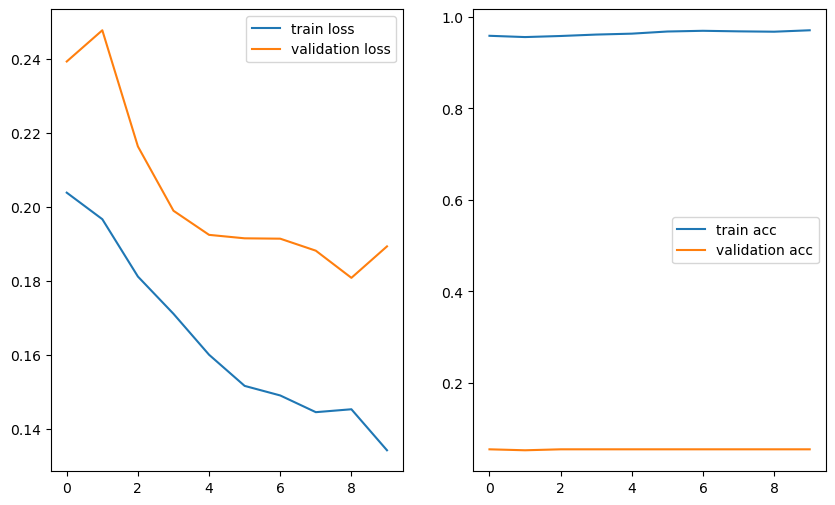

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train loss')
plt.plot(validation_losses, label='validation loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train acc')
plt.plot(validation_accs, label='validation acc')
plt.legend()